In [2]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import matplotlib.patches as patches
import math

import cv2
from PIL import Image

import SimpleITK as sitk
from torchio.transforms import Affine
from torchio import Image

from pathlib import Path

from bs4 import BeautifulSoup
import json

In [3]:
def read_crop_info(file_name):
    
    with open(file_name, "r") as fp:
        crop_info = json.load(fp)
        
    return crop_info

def read_rotation_info(file_name):
    
    with open(file_name, "r") as fp:
        rot = json.load(fp)
        
        
        #rotation_info = {'x_dir': {'x': x_dir.getX(), 'y': x_dir.getY(), 'z': z_dir.getZ()},
        #             'y_dir': {'x': y_dir.getX(), 'y': y_dir.getY(), 'z': y_dir.getZ()},
        #             'z_dir': {'x': z_dir.getX(), 'y': z_dir.getY(), 'z': z_dir.getZ()}
        #            }
        
    x = [rot['x_dir']['x'], rot['x_dir']['y'], rot['x_dir']['z']]
    y = [rot['y_dir']['x'], rot['y_dir']['y'], rot['y_dir']['z']]
    z = [rot['z_dir']['x'], rot['z_dir']['y'], rot['z_dir']['z']]
    
  
    return x,y,z
    

def read_dragonfly_transform(file_name):
    
    with open(str(file_name), 'r') as f:
        data = f.read()

#print(data[12:])

    xml_data = BeautifulSoup(data[12:], "xml")

    #print(xml_data)

    x_dir = xml_data.find('direction0')
    y_dir = xml_data.find('direction1')
    z_dir = xml_data.find('direction2')

    x2 = [float(x_dir.get('x')), float(x_dir.get('y')), float(x_dir.get('z'))]
    y2 = [float(y_dir.get('x')), float(y_dir.get('y')), float(y_dir.get('z'))]
    z2 = [float(z_dir.get('x')), float(z_dir.get('y')), float(z_dir.get('z'))]
    
    f.close()
    
    return x2,y2,z2


def save_np_as_multitiff_stack(volume, file_name):
    
    imlist = []
    for i in range(volume.shape[0]):
        imlist.append(Image.fromarray(volume[i]))

    imlist[0].save(file_name, save_all=True, append_images=imlist[1:])
    
    del imlist 
    
def rotate_dataset(dataset, image_data, angles):

    x = [1, 0, 0]
    y = [0, 1, 0]
    z = [0, 0, 1]

    #x2,y2,z2 = read_dragonfly_transform(path / 'transform.ORSObject')

    res_rot = R.align_vectors(angles, [z,y,x])
    rotation_degrees = res_rot[0].as_euler('zyx', degrees=True)

    #res_rot = R.align_vectors([x2,y2,z2],[x,y,z])
    #rotation_degrees = res_rot[0].as_euler('xyz', degrees=True)


    #print('Original:', rotation_degrees)

    #degrees = -rotation_degrees
    degrees = -rotation_degrees

    # [z,y,x]
    #degrees = [0,0,-10]

    rot_x = degrees[2]
    rot_y = degrees[1]
    rot_z = degrees[0]

    print('Rotation:', degrees)

    if True:

        img_rotation = Affine(scales=[1.0, 1.0, 1.0], degrees=degrees, translation=[0,0,0],
                                      center='image')

        img_rotation_x = Affine(scales=[1.0, 1.0, 1.0], degrees=[0,0,rot_x], translation=[0,0,0],
                                      center='image')
        img_rotation_y = Affine(scales=[1.0, 1.0, 1.0], degrees=[0,rot_y,0], translation=[0,0,0],
                                      center='image')
        img_rotation_z = Affine(scales=[1.0, 1.0, 1.0], degrees=[rot_z,0,0], translation=[0,0,0],
                                      center='image')


  
        print('Image shape', image_data.shape)

        image_rotated_z = img_rotation_z(np.expand_dims(image_data, axis=0))[0]
        image_rotated_zy = img_rotation_y(np.expand_dims(image_rotated_z, axis=0))[0]
        del image_rotated_z
        image_rotated = img_rotation_x(np.expand_dims(image_rotated_zy, axis=0))[0]
        del image_rotated_zy

        print('Image shape', image_rotated.shape)
        print(image_rotated.dtype)

        #result_image = sitk.GetImageFromArray(image_rotated.transpose(2, 1, 0))
        print('Done!')
        
        return image_rotated
    
def plot_volume_slices(image):
    fig, axs = plt.subplots(3)
    fig.set_size_inches(15, 15, forward=True)

    #plt.imshow(image_rotated[int(d/2 + tip_d/2)], cmap='gray')
    axs[0].imshow(image[int(image.shape[0]/2)], cmap='gray')
    #axs[0].set_title(dataset)

    #axs[1].imshow(np.fliplr(image[:,:,int(image.shape[2]/2)].T), cmap='gray')
    #axs[2].imshow(np.fliplr(image[:,int(image.shape[1]/2),:].T), cmap='gray')
    
    axs[1].imshow(image[:,:,int(image.shape[2]/2)].T, cmap='gray')
    axs[2].imshow(image[:,int(image.shape[1]/2),:].T, cmap='gray')
    

In [4]:
#path = Path("c:\\Users\\fe0968\\Documents\\data\\medaka\\")
#path = Path("c:\\Users\\fe0968\\Documents\\data\\medaka\\landmarks\\data_for_workshop\\scaled\\")

# Xenopus
#data_path = Path("c:\\Users\\fe0968\\Documents\\data\\xenopus\\align\\")
data_path = Path("z:\\tomo\\ershov\\xenopus\\_alignment")
align_path = Path("z:\\tomo\\ershov\\xenopus\\_alignment\\test\\")
res_path = Path("z:\\tomo\\ershov\\xenopus\\_alignment\\test_results\\")

# Medaka
data_path = Path("z:\\tomo\\ershov\\medaka\\workshop_landmarks\\scaled\\")
align_path = Path("c:\\Users\\fe0968\\Documents\\Medaka\\_alignment_info_new\\")
res_path = Path("c:\\Users\\fe0968\\Documents\\Medaka\\_alignment_info_new\\")

#dataset = '807'

#dataset_list = ['A2p1_16_5','A2p1_18_05', 'A2p0_20_01', 'A2p0_21_4', 'A2p1_23_07','A2p2_22_05']
#dataset_list = ['A2p2_22_05']

dataset_list = ['1273']

slices = {'A2p1_16_5': [505, 504, 588],
          'A2p1_18_05': [493, 504, 505],
          'A2p1_23_07': [432, 504, 424],
          'A2p2_22_05': [666, 757, 651],
          'A2p0_20_01': [398, 504, 657],
          'A2p0_21_4': [467, 504, 457]
          
}

Processing: 1273
Rotation: [-178.00967467    5.34866316   -7.83935729]
Image shape (1620, 504, 504)
Image shape (1620, 504, 504)
float32
Done!


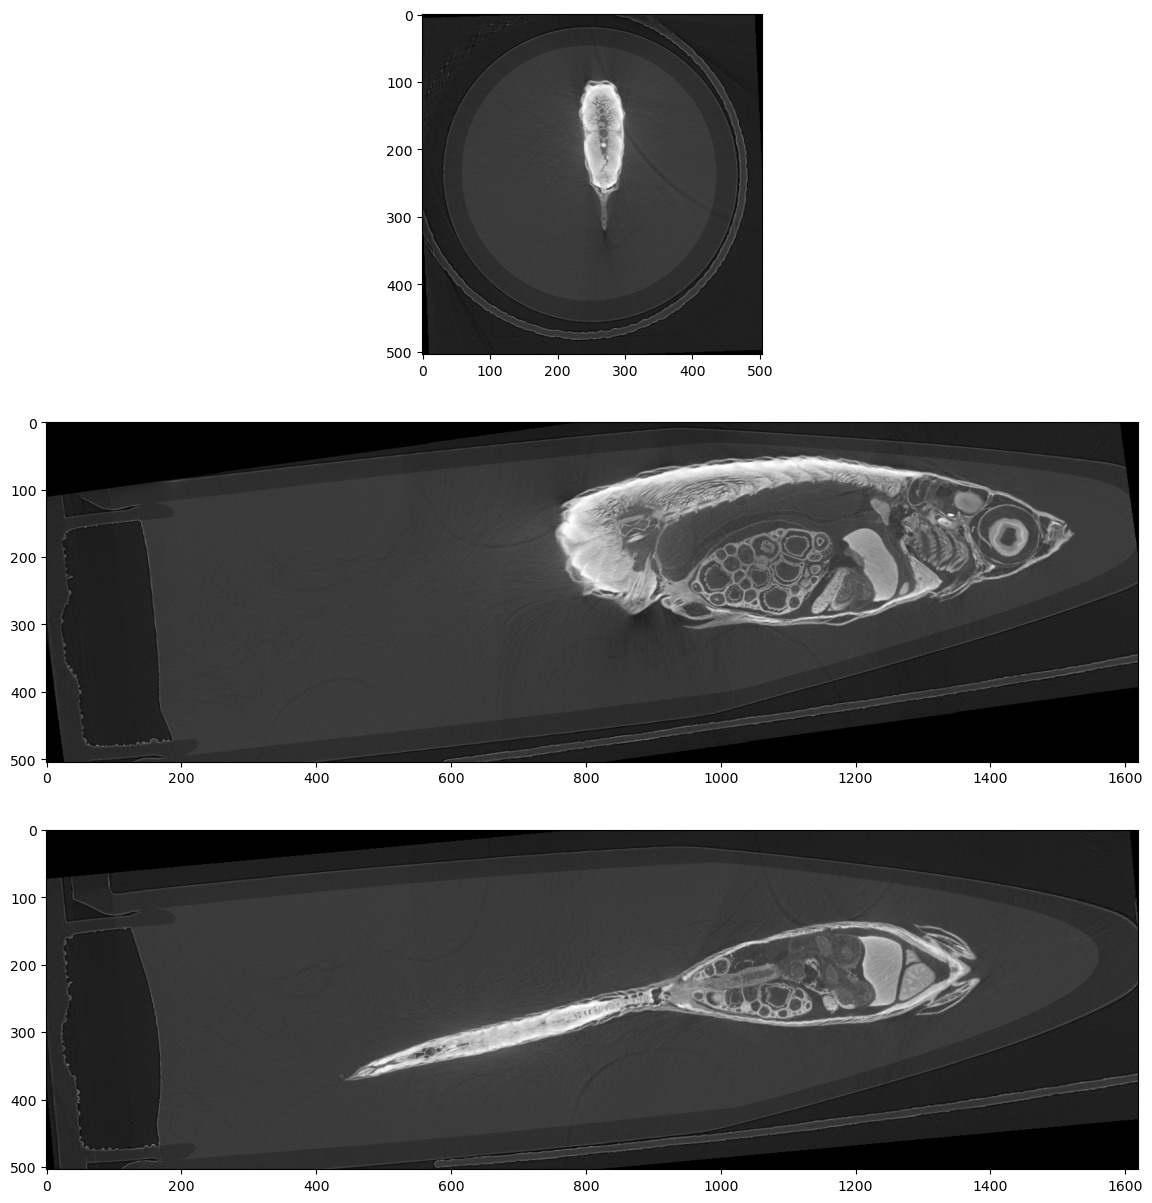

In [23]:


for d in dataset_list:

    dataset = d
    print(f'Processing: {d}')
    #sitk_image = sitk.ReadImage(data_path / f'{dataset}_scaled.tif')
    sitk_image = sitk.ReadImage(data_path / f'{dataset}.tif')
    image_data = sitk.GetArrayFromImage(sitk_image).astype('uint8')
    
    x2,y2,z2 = read_rotation_info(align_path / f'{dataset}_rot_info.txt')
    #cr = read_crop_info(align_path / f'{dataset}_crop_info.txt')
    
    
    image_rotated = rotate_dataset(dataset, image_data, [z2,y2,x2])
    
    plot_volume_slices(image_rotated)
    
    if False:
        fig = plt.figure(figsize= (10,10), layout="tight")

        gs = GridSpec(2, 2, figure=fig)
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[1, 0])
        ax3 = fig.add_subplot(gs[0, 1])
        ax4 = fig.add_subplot(gs[1, 1])

        c = 1008
        sx = math.floor(slices[dataset][0]*0.5)
        sy = math.floor(slices[dataset][1]*0.5)
        sz = math.floor(slices[dataset][2]*0.5)

        ax1.imshow(np.zeros((504,504)), cmap='gray')
        ax1.axis('off')
        #plt.show()

        ax2.imshow(image_rotated[sz], cmap='gray')
        ax2.axis('off')
        rect = patches.Rectangle((math.floor(cr['x']/2), math.floor(cr['y']/2)), math.floor(cr['w']/2), math.floor(cr['h']/2), linewidth=1, edgecolor='g', facecolor='none')
        ax2.add_patch(rect)
        ax2.plot(math.floor(cr['x']/2) + math.floor(cr['w']/4),math.floor(cr['y']/2)+math.floor(cr['h']/4),'go') 
        #plt.show()

        print(sy)
        ax3.imshow(image_rotated[:,sy,:], cmap='gray')
        ax3.axis('off')
        rect = patches.Rectangle((math.floor(cr['x']/2), math.floor(cr['z']/2)), math.floor(cr['w']/2), math.floor(cr['d']/2), linewidth=1, edgecolor='g', facecolor='none')
        ax3.add_patch(rect)
        ax3.plot(math.floor(cr['x']/2) + math.floor(cr['w']/4),math.floor(cr['z']/2)+math.floor(cr['d']/4),'go') 
        #plt.show()

        ax4.imshow(image_rotated[:,:,sx], cmap='gray')
        ax4.axis('off')
        rect = patches.Rectangle((math.floor(cr['y']/2), math.floor(cr['z']/2)), math.floor(cr['h']/2), math.floor(cr['d']/2), linewidth=1, edgecolor='g', facecolor='none')
        ax4.add_patch(rect)
        ax4.plot(math.floor(cr['y']/2) + math.floor(cr['h']/4),math.floor(cr['z']/2)+math.floor(cr['d']/4),'go') 
        #plt.show()

        fig.savefig(res_path / f'{dataset}.png')

    


In [21]:
sitk_image = sitk.GetImageFromArray(image_rotated.astype('uint8'))
sitk.WriteImage(sitk_image, res_path / f'test_rotated.tif')

## Testing

In [5]:
x = [1, 0, 0]
y = [0, 1, 0]
z = [0, 0, 1]



r1 = R.from_euler('xyz', [0, 45, 0], degrees=True)

x2 = r1.apply(x)
print(x2)

y2 = r1.apply(y)
print(y2)

z2 = r1.apply(z)
print(z2)

[ 0.70710678  0.         -0.70710678]
[0. 1. 0.]
[0.70710678 0.         0.70710678]


In [6]:
x2 = [0.70805369178113231, 3.7762687912420295e-17, -0.70615860085048132]
y2 = [0, 1, 0]
z2 = [0.70615860085048132, -2.9216395384872545e-17, 0.7080536917811322]

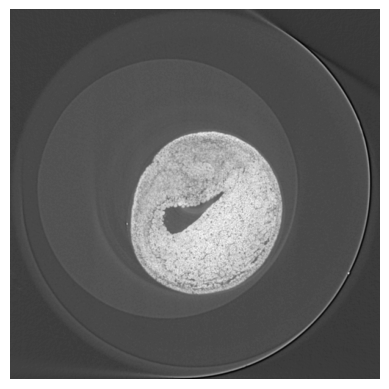

In [120]:
plt.imshow(sitk.GetArrayViewFromImage(sitk_image)[293], cmap= 'gray')
plt.axis('off');

## Rotate

In [121]:
#rotation_radians = np.radians(rotation_degrees).tolist()
#otation_degrees = [0,0,30]


    



Original: [-98.37994653  32.63476168 -70.97437601]
Corrected: [ 98.37994653 -32.63476168  70.97437601]
Image shape (504, 504, 504)
Image shape (504, 504, 504)
float32
Done!


{'x': 161, 'y': 53, 'z': 169, 'w': 649, 'h': 645, 'd': 631}


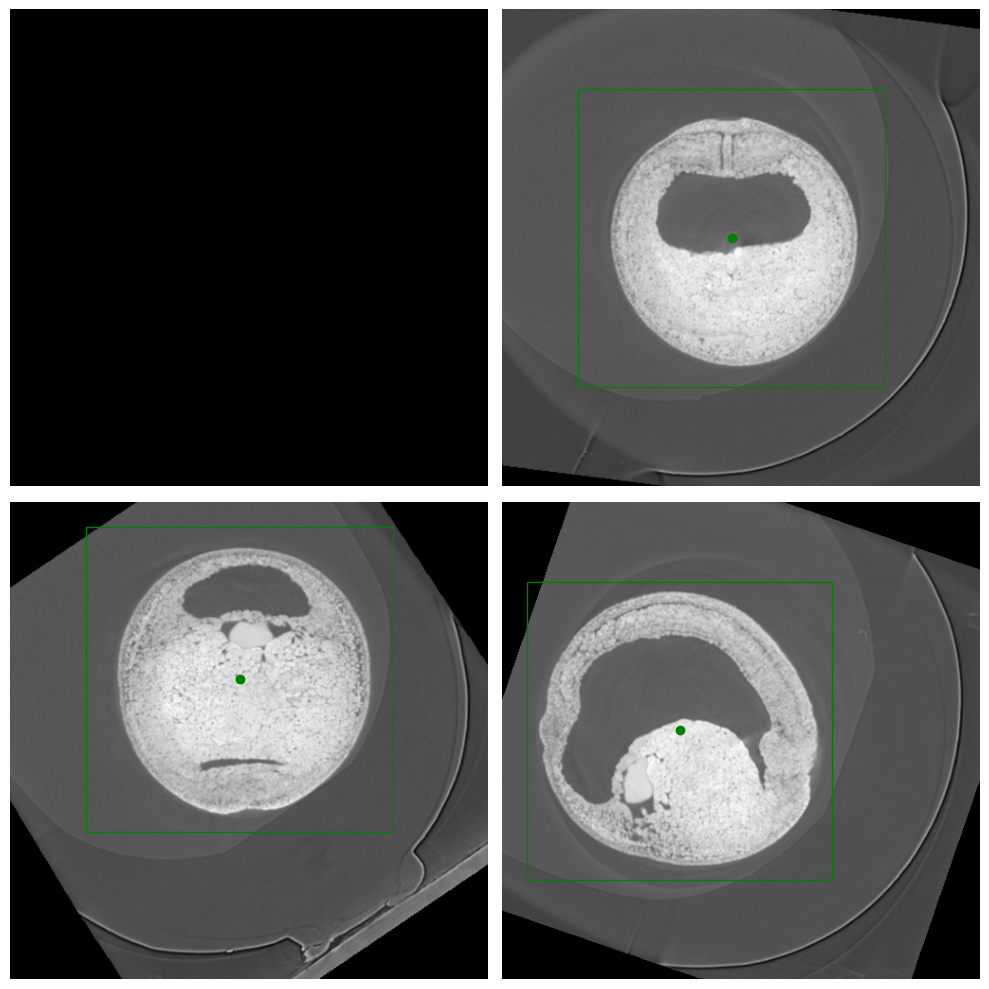

## Crop

In [49]:
cr = read_crop_info(path / f'{dataset}_crop_info.txt')
image_crop = image_rotated[cr['z']:cr['z']+cr['d'], cr['y']:cr['y']+cr['h'], cr['x']:cr['x']+cr['w']]

In [50]:
%%time
save_np_as_multitiff_stack(image_crop.astype('uint8'), f'test_rotated_crop.tif')

Wall time: 5.51 s


In [17]:
%%time
save_np_as_multitiff_stack(image_rotated.astype('uint8'), f'test_rotated.tif')

AttributeError: type object 'Image' has no attribute 'fromarray'

In [45]:
%%time
sitk_image = sitk.GetImageFromArray(image_rotated.astype('uint8'))
sitk.WriteImage(sitk_image, f'test_rotated.tif')

Wall time: 23.4 s


In [220]:
# open file in write mode
with open('info.txt', 'w') as fp:
    for item in degrees:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


## Dragonfly script 

In [225]:
from OrsHelpers.viewLogger import ViewLogger
from OrsPlugins.orsimageloader import OrsImageLoader
from OrsHelpers.managedhelper import ManagedHelper
from OrsHelpers.datasethelper import DatasetHelper
from OrsHelpers.layoutpropertieshelper import LayoutPropertiesHelper
from OrsPythonPlugins.OrsObjectPropertiesList.OrsObjectPropertiesList import OrsObjectPropertiesList
from OrsPythonPlugins.OrsDerivedDataset.OrsDerivedDataset import OrsDerivedDataset
from OrsHelpers.roihelper import ROIHelper
from OrsHelpers.structuredGridLogger import StructuredGridLogger
from OrsHelpers.structuredGridHelper import StructuredGridHelper
from OrsHelpers.reporthelper import ReportHelper
from PIL import Image
import math

#--------------------------------------------------------------
# Global settings
#--------------------------------------------------------------
#PATH_INPUT_FOLDER = 'c:/Users/fe0968/Documents/data/medaka/landmarks/data_for_workshop/scaled/'
#PATH_OUTPUT_INFO_FOLDER = 'c:/Users/fe0968/Documents/data/medaka/landmarks/data_for_workshop/scaled/'
#dataset_list = ['800', '801', '803', '804', '805', '807', '809', '1075']

PATH_INPUT_FOLDER = 'c:/Users/fe0968/Documents/data/xenopus/align/'
PATH_OUTPUT_INFO_FOLDER = 'c:/Users/fe0968/Documents/data/xenopus/align/'

dataset_list = ['A2p1_18_05']


#SPACING = 1.23e-06 # Pixel size in micrometers
SPACING = 0.001 # Pixel size in micrometers

current_dataset = 'no'
current_index = 0

def read_dataset_list():
    print(f'Datasets')
    return

def load_next_dataset():
    
    global current_index
    global current_dataset
    
    current_dataset = dataset_list[current_index]
    vol = load_volume(current_dataset + '.tif')
    
    current_index = current_index+1
    
    return vol

def load_next_dataset_and_copy():
    
    vol = load_next_dataset()
    rot = make_copy(vol)
    
    return vol, rot

def get_volume_size(volume_path):

    im = Image.open(volume_path)
    return (im.size[0], im.size[1], im.n_frames)

def load_volume(volume_file_name = 'fA2p0_17_2_s_eig16_new_sagittal.tif'):

    fileNamesListElement = PATH_INPUT_FOLDER + volume_file_name
    fileNames = [fileNamesListElement]

    vol_size = get_volume_size(PATH_INPUT_FOLDER + volume_file_name)

    #xSize = 1048
    #ySize = 1140
    #zSize = 1116

    xSize = vol_size[0]
    ySize = vol_size[1]
    zSize = vol_size[2]
    tSize = 1
    minX = 0
    maxX = xSize -1
    minY = 0
    maxY = ySize -1
    minZ = 0
    maxZ = zSize -1
    xSampling = 1
    ySampling = 1
    zSampling = 1
    tSampling = 1
    xSpacing = SPACING
    ySpacing = SPACING
    zSpacing = SPACING
    slope = 1.0
    offset = 0.0
    dataUnit = ''
    invertX = False
    invertY = False
    invertZ = False
    axesTransformation = 0
    datasetName = volume_file_name
    convertFrom32To16bits = False
    dataRangeMin = 0.0
    dataRangeMax = 0.0
    frameCount = 1

    additionalInfo = 'PD94bWwgdmVyc2lvbj0iMS4wIj8+CjxJbWFnZUxvYWRlck1vZGVsIElzRGF0YVJHQj0iZmFsc2UiIFJHQk91dHB1dD0iMCIgSW52ZXJ0SW50ZW5zaXR5PSJmYWxzZSIgLz4K'


    output = OrsImageLoader.createDatasetFromFiles(fileNames=fileNames,
                                                xSize=xSize,
                                                ySize=ySize,
                                                zSize=zSize,
                                                tSize=tSize,
                                                minX=minX,
                                                maxX=maxX,
                                                minY=minY,
                                                maxY=maxY,
                                                minZ=minZ,
                                                maxZ=maxZ,
                                                xSampling=xSampling,
                                                ySampling=ySampling,
                                                zSampling=zSampling,
                                                tSampling=tSampling,
                                                xSpacing=xSpacing,
                                                ySpacing=ySpacing,
                                                zSpacing=zSpacing,
                                                slope=slope,
                                                offset=offset,
                                                dataUnit=dataUnit,
                                                invertX=invertX,
                                                invertY=invertY,
                                                invertZ=invertZ,
                                                axesTransformation=axesTransformation,
                                                datasetName=datasetName,
                                                convertFrom32To16bits=convertFrom32To16bits,
                                                dataRangeMin=dataRangeMin,
                                                dataRangeMax=dataRangeMax,
                                                frameCount=frameCount,
                                                additionalInfo=additionalInfo)

    volume_channel = output[0]
    ManagedHelper.publish(anObject=volume_channel)

    name = 'toplayout\\scene_0'
    isVisible = True
    
    DatasetHelper.setIsVisibleIn2DFromGenealogicalName(name=name,
                                                    dataset=volume_channel,
                                                    isVisible=isVisible)

  

    layoutFullName = 'toplayout\\scene_0'
    lutUUID = '7b00da82eefc11e68693448a5b87686a'
    aScalarValueTypeTag = ''
 
    LayoutPropertiesHelper.set3DLUTUUIDFromGenealogicalName(layoutFullName=layoutFullName,
                                                            anObject=volume_channel,
                                                            lutUUID=lutUUID,
                                                            aScalarValueTypeTag=aScalarValueTypeTag)


    return volume_channel

def make_copy(dataset):
    
    d = DatasetHelper.copyDataset(aDataset=dataset)
    
    d.setTitle(newVal='aligned', logging=True)
    
    d.publish(logging=True)
    
    name = 'toplayout\\scene_0'

    DatasetHelper.setIsVisibleIn2DFromGenealogicalName(name=name,
                                                       dataset=d,
                                                       isVisible=True)
    return d

def resample(orig_dataset, resampled_dataset):
    newTitle_3 = 'aligned (Resampled)'


    derivedDataset = OrsDerivedDataset.copyStructuredGridIntoAnotherShape(sourceStructuredGrid=resampled_dataset,
                                                                         referenceStructureGrid=orig_dataset,
                                                                         newTitle=newTitle_3)
    
    derivedDataset.publish(logging=True)
    
    name = 'toplayout\\scene_0'

    DatasetHelper.setIsVisibleIn2DFromGenealogicalName(name=name,
                                                       dataset=derivedDataset,
                                                       isVisible=True)
    
    return derivedDataset

def save_crop_box_info(im, file_name='crop'):
    v,d = StructuredGridHelper.getClipBoxForCurrentView(im)
    b = v.getBox(0)
    
    crop_info = {'x': math.floor(b.getOrigin().getX() / SPACING  + 1),
                'y': math.floor(b.getOrigin().getY() / SPACING + 1),
                'z': math.floor(b.getOrigin().getZ() / SPACING + 1),
                'w': math.floor(b.getDirection0Size() / SPACING + 0.5),
                'h': math.floor(b.getDirection1Size() / SPACING + 0.5),
                'd': math.floor(b.getDirection2Size() / SPACING + 0.5)
                    }
    
    with open(PATH_OUTPUT_INFO_FOLDER + file_name + '_crop_info.txt', "w") as fp:
        json.dump(crop_info, fp)  # encode dict into JSON
        
    print(f'Dataset: {file_name}: Croppping info is saved')
    
    
def save_rotation_info(im, file_name='rot'):
    b = im.getBox()
    
    x_dir = b.getDirection0()
    y_dir = b.getDirection1()
    z_dir = b.getDirection2()
    
    rotation_info = {'x_dir': {'x': x_dir.getX(), 'y': x_dir.getY(), 'z': x_dir.getZ()},
                     'y_dir': {'x': y_dir.getX(), 'y': y_dir.getY(), 'z': y_dir.getZ()},
                     'z_dir': {'x': z_dir.getX(), 'y': z_dir.getY(), 'z': z_dir.getZ()}
                    }
    
    with open(PATH_OUTPUT_INFO_FOLDER + file_name + '_rot_info.txt', "w") as fp:
        json.dump(rotation_info, fp)  # encode dict into JSON 
        
    print(f'Dataset: {file_name}: Rotation info is saved')
        
def clean(vol):
    DatasetHelper.deleteDataset(aDataset=vol)
    
def clean_all():
    global vol
    global rot
    global res
    
    DatasetHelper.deleteDataset(aDataset=vol)
    DatasetHelper.deleteDataset(aDataset=rot)  
    DatasetHelper.deleteDataset(aDataset=res)  
    
def save_all_info():
    global vol
    save_rotation_info(rot, current_dataset)
    save_crop_box_info(res, current_dataset)
    

## Steps

In [222]:
# 1. Modify data paths in the script

# 2. Copy-pase the script tinto Dragonfly's Python Console ("Utilities - Python Console")

# 3. Load next volume

# Option 1: Load volume manually
#vol = load_volume('800.tif')

# Make a copy if we need to make Cropping (needs a resampled copy)
rot = make_copy(vol)

# Option 2: Load volume from the dataset list
vol = load_next_dataset()

# Make a copy if we need to make Cropping (needs a resampled copy)
rot = make_copy(vol)

# Option 3: Load volume from the dataset list and make a copy
vol, rot = load_next_dataset_and_copy()

##---------------------------------
# 4. Manually align the rotation
##---------------------------------
save_rotation_info(rot, '807)

res = resample(vol, rot)

# 5. Manually align the cropping box

save_crop_box_info(res, '807')
                   
# 6. Clean
clean_all()
                   
# Repeat
                   

In [ ]:
vol, rot = load_next_dataset_and_copy()
res = resample(vol, rot)
clean_all()

In [ ]:
b = im.getBox()
x = b.getDirection0().getX()
print(x)

In [9]:
path = Path("c:\\Users\\fe0968\\Documents\\data\\medaka\\landmarks\\data_for_workshop\\scaled\\")

In [14]:
read_rotation_info(path / '807_rot_info.txt')

([0.9112168911367365, -0.33506703082140044, 0.9480826063631126],
 [0.3854578165965902, 0.8987195125713549, 0.2091064545825776],
 [0.14527921025284518, -0.2829016128975527, 0.9480826063631126])

In [42]:
import time

In [41]:
%%time
c = 1

Wall time: 1 ms


In [43]:
%%time
time.sleep(2.4)

Wall time: 2.4 s


In [1]:
from Geometry3D import *

In [ ]:
l1 = Line(Point(1,2,1), Point(5,6,1))
l2 = Line(Point(2,6,1), Point(5,4,1))

s1 = Segment(Point(1,2,0), Point(5,6,0))
s2 = Segment(Point(2,6,0), Point(5,4,0))

#inter = intersection(l2, l2)
intersection(s1,s2)



In [5]:
data_path = Path("z:\\tomo\\ershov\\medaka\\workshop_landmarks\\data\\")

In [13]:
from os import listdir
from os.path import isfile, join

onlyfiles = [f.split('.')[0] for f in listdir(data_path) if isfile(join(data_path, f))]

In [14]:
%pprint
list(onlyfiles)

Pretty printing has been turned OFF


['1064', '1071', '1075', '1076', '1081', '1082', '1086', '1100', '1104', '1105', '1106', '1119', '1126', '1129', '1131', '1134', '1149', '1155', '1157', '1170', '1181', '1184', '1185', '1191', '1192', '1197', '1216', '1217', '1219', '1222', '1226', '1227', '1230', '1232', '1234', '1248', '1256', '1257', '1258', '1264', '1265', '1269', '1273', '1274', '1282', '1284', '1285', '1291', '1292', '1293', '1295', '1296', '1297', '1300', '1305', '1310', '1320', '1321', '1323', '1337', '1338', '1341', '1346', '1351', '1353', '1362', '1363', '1366', '1369', '1370', '1372', '1376', '1378', '1380', '1383', '1384', '1385', '1389', '1391', '1393', '1394', '1395', '1396', '1399', '1400', '1401', '1404', '1405', '1406', '1412', '1413', '1414', '1417', '1418', '1423', '417', '418', '421', '423', '425', '428', '444', '446', '448', '454', '459', '463', '470', '471', '475', '488', '489', '493', '500', '501', '502', '508', '509', '511', '526', '528', '531', '535', '537', '547', '555', '561', '565', '578', '

In [8]:
listdir(data_path)

[]

In [18]:
for f in onlyfiles:
    print(f'"{f}",', end='')

"1064","1071","1075","1076","1081","1082","1086","1100","1104","1105","1106","1119","1126","1129","1131","1134","1149","1155","1157","1170","1181","1184","1185","1191","1192","1197","1216","1217","1219","1222","1226","1227","1230","1232","1234","1248","1256","1257","1258","1264","1265","1269","1273","1274","1282","1284","1285","1291","1292","1293","1295","1296","1297","1300","1305","1310","1320","1321","1323","1337","1338","1341","1346","1351","1353","1362","1363","1366","1369","1370","1372","1376","1378","1380","1383","1384","1385","1389","1391","1393","1394","1395","1396","1399","1400","1401","1404","1405","1406","1412","1413","1414","1417","1418","1423","417","418","421","423","425","428","444","446","448","454","459","463","470","471","475","488","489","493","500","501","502","508","509","511","526","528","531","535","537","547","555","561","565","578","582","586","601","603","605","606","608","610","613","614","619","622","626","629","639","640","641","649","652","660","679","684"